In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [2]:
class Discriminator(nn.Module):
  def __init__(self, img_channels, features):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(
            img_channels, features, kernel_size =4, stride =2,padding =1
            ),
        nn.LeakyReLU(0.2),
        self.disc_block(features, features*2, 4, 2, 1),
        self.disc_block(features*2, features*4, 4, 2, 1),
        self.disc_block(features*4, features*8, 4, 2, 1),
        nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
        nn.Sigmoid(),
        )

  def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
      return self.disc(x)

In [3]:
class Generator(nn.Module):

  def __init__(self, z_dim, img_channels, features):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        self.gen_block(z_dim, features*16, 4, 1, 0),
        self.gen_block(features*16, features*8, 4, 2, 1),
        self.gen_block(features*8, features*4, 4, 2, 1),
        self.gen_block(features*4, features*2, 4, 2, 1),
        nn.ConvTranspose2d(
            features*2, img_channels, kernel_size=4, stride=2, padding=1,
        ),
        nn.Tanh(),
    )
  def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.ConvTranspose2d(
              in_channels, out_channels,
              kernel_size, stride,
              padding, bias = False,
          ),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
      )

  def forward(self, x):
      return self.gen(x)


In [4]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
from PIL import Image
import os

def Load_img(folder_path):
    pokemon = []
    for foldername in os.listdir(folder_path):
        folder_full_path = os.path.join(folder_path, foldername)
        for filename in os.listdir(folder_full_path):
            img_path = os.path.join(folder_full_path, filename)
            pokemon_image = Image.open(img_path).convert("RGB")
            pokemon_image = pokemon_image.resize((64, 64))
            pokemon.append(pokemon_image)
    return pokemon


In [6]:
folder_path = 'C:/Users/tusha/Downloads/pokemon/pokemon'
pokemon = Load_img(folder_path)

print(len(pokemon))

c:\Users\tusha\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40597


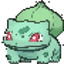

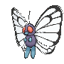

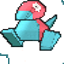

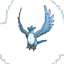

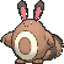

In [7]:
a = [5, 1500, 2500, 3000, 4000]
for i in a:
  display(pokemon[i])

In [8]:
class POKEdataset(Dataset):
  def __init__(self, pokemon, transform = None):
    self.poke_img = pokemon
    self.transform = transform

  def __len__(self):
    return len(self.poke_img)

  def __getitem__(self, idx):
    img = self.poke_img[idx]
    if self.transform:
      img = self.transform(img)
    return img

In [9]:
from torch.utils.tensorboard import SummaryWriter

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learn_rate  = 2e-4
batch_size = 128
image_size = 64
img_channels = 3
z_dim = 100
num_epochs = 5
features = 64

Transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = POKEdataset(pokemon, transform = Transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
gen = Generator(z_dim, img_channels, features).to(device)
disc = Discriminator(img_channels, features).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = learn_rate, betas = (0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr = learn_rate, betas = (0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(num_epochs):
  for batch_idx, real in enumerate(loader):
    real = real.to(device)
    noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
    fake = gen(noise)

    disc_real = disc(real).view(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(gen(noise)).view(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    disc.zero_grad()
    loss_disc.backward(retain_graph = True)
    opt_disc.step()

    output = disc(fake).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_idx % 100 == 0:

      print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}")

      with torch.no_grad():
        fake = gen(fixed_noise)
        img_grid_real = torchvision.utils.make_grid(
            real[:32], normalize = True
        )
        img_grid_fake = torchvision.utils.make_grid(
            fake[:32], normalize = True
        )
        writer_real.add_image(
            "Real", img_grid_real, global_step = step
        )
        writer_fake.add_image(
            "Fake", img_grid_fake, global_step = step
        )
        
    step +=1

Epoch [0/5] Batch 0
Epoch [0/5] Batch 100
Epoch [0/5] Batch 200
Epoch [0/5] Batch 300
Epoch [1/5] Batch 0
Epoch [1/5] Batch 100
Epoch [1/5] Batch 200
Epoch [1/5] Batch 300
Epoch [2/5] Batch 0
Epoch [2/5] Batch 100
Epoch [2/5] Batch 200
Epoch [2/5] Batch 300
Epoch [3/5] Batch 0
Epoch [3/5] Batch 100
Epoch [3/5] Batch 200
Epoch [3/5] Batch 300
Epoch [4/5] Batch 0
Epoch [4/5] Batch 100
Epoch [4/5] Batch 200
Epoch [4/5] Batch 300


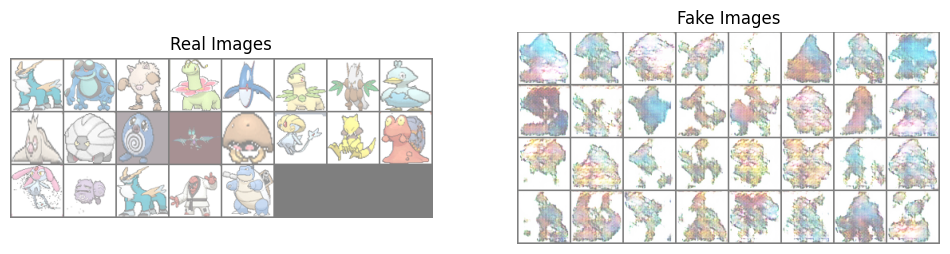

In [12]:
import matplotlib.pyplot as plt

def show_images(real, fake):
   
    real = real.permute(1, 2, 0).cpu().numpy()
    fake = fake.permute(1, 2, 0).cpu().numpy()
    
    
    real = (real * 0.5) + 0.5
    fake = (fake * 0.5) + 0.5
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(real)
    axes[0].set_title('Real Images')
    axes[0].axis('off')
    
    axes[1].imshow(fake)
    axes[1].set_title('Fake Images')
    axes[1].axis('off')
    
    plt.show()


with torch.no_grad():
    fake = gen(fixed_noise)
    img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
    img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
    show_images(img_grid_real, img_grid_fake)
